In [2]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from kalman import KalmanNet, LDSNet, c_to_d_kf

In [37]:
def build_kalman_test_net(neurons, A, B, C, Q, R, dt, stim_fun):
    """Set up a nengo network to test a Kalman filter"""
    A_DT, B_DT, Q_DT = c_to_d_kf(A, B, Q, dt=dt)
    model = nengo.Network()
    with model:
        stim = nengo.Node(stim_fun)
        lds_net = LDSNet(A, B, C, Q=Q/dt, R=R)
        nengo.Connection(stim, lds_net.input, synapse=None)
        stim_probe = nengo.Probe(stim)
        lds_state_probe = nengo.Probe(lds_net.state)
        lds_out_probe = nengo.Probe(lds_net.output)
        
        kalman_net = KalmanNet(neurons, A_DT, B_DT, C, Q_DT, R, dt=dt)
        nengo.Connection(stim, kalman_net.input_system, synapse=None)
        nengo.Connection(lds_net.output, kalman_net.input_measurement, synapse=None)
        
        kalman_rate = KalmanNet(neurons, A_DT, B_DT, C, Q_DT, R, dt=dt, neuron_type=nengo.neurons.LIFRate())
        nengo.Connection(stim, kalman_rate.input_system, synapse=None)
        nengo.Connection(lds_net.output, kalman_rate.input_measurement, synapse=None)

        kalman_ref = KalmanNet(1, A_DT, B_DT, C, Q_DT, R, dt=dt, neuron_type=nengo.neurons.Direct())
        nengo.Connection(stim, kalman_ref.input_system, synapse=None)
        nengo.Connection(lds_net.output, kalman_ref.input_measurement, synapse=None)
                
        k_ref_probe = nengo.Probe(kalman_ref.readout)
        k_rate_probe = nengo.Probe(kalman_rate.readout)
        k_probe = nengo.Probe(kalman_net.readout)
        
        probes = dict(
            stim=stim_probe,
            lds_state=lds_state_probe, lds_out=lds_out_probe,
            k_ref=k_ref_probe, k_rate=k_rate_probe, k=k_probe)
    return model, probes

Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:02.                                                                                                                                                                                     


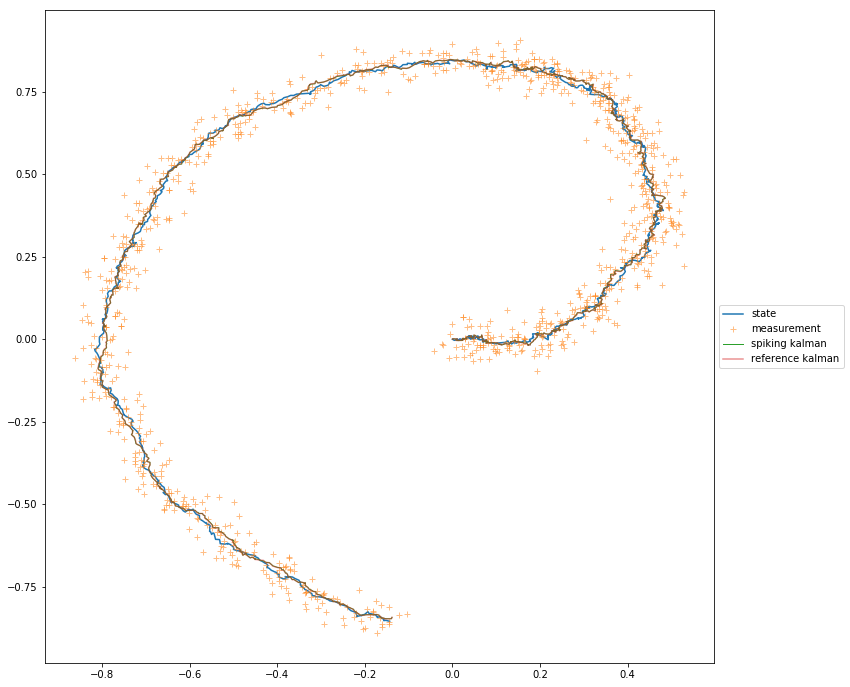

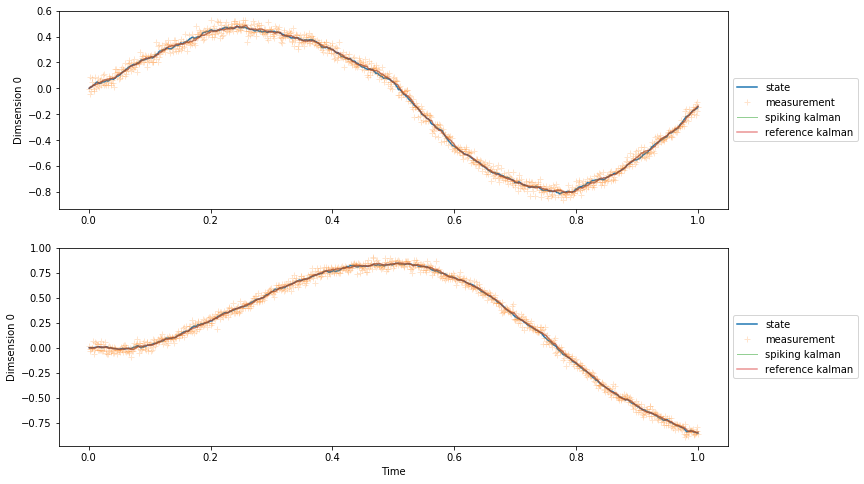

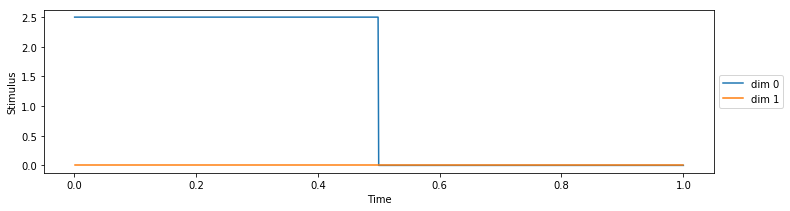

In [48]:
def test_knet_2d():
    """Test a Kalman filter's ability to track a 2D rotational system"""
    SIM_TIME = 1.0
    STIM_TIME = 0.5
    NEURONS = 1024
    STIM = [2.5, 0]
    
    DELTA_T = 0.001 # discretization time
    FREQ = 1.
    A = 2*np.pi*FREQ*np.array([[0, -1], [1, 0]])
    B = np.eye(2)
    C = np.eye(2)
    Q = 0.01*np.eye(2)
    R = 0.001*np.eye(2)
    
    def test_stim(t, stim, stop_time):
        if t < stop_time:
            return stim
        else:
            return [0, 0]
    
    model, probes = build_kalman_test_net(
        NEURONS, A, B, C, Q, R, dt=DELTA_T, stim_fun=lambda t: test_stim(t, STIM, STIM_TIME))
   
    sim = nengo.Simulator(model, dt=DELTA_T)
    sim.run(SIM_TIME)
    
    fig, axs = plt.subplots(figsize=(12, 12))
    axs.plot(sim.data[probes["lds_state"]][:, 0], sim.data[probes["lds_state"]][:, 1], label="state")
    axs.plot(sim.data[probes["lds_out"]][:, 0], sim.data[probes["lds_out"]][:, 1], "+", alpha=0.5, label="measurement")
    axs.plot(sim.data[probes["k"]][:, 0], sim.data[probes["k"]][:, 1], alpha=1, lw=1, label="spiking kalman")
    axs.plot(sim.data[probes["k_ref"]][:, 0], sim.data[probes["k_ref"]][:, 1], alpha=0.5, label="reference kalman")
    axs.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
    fig, axs = plt.subplots(nrows=2, figsize=(12, 8))
    axs[0].plot(sim.trange(), sim.data[probes["lds_state"]][:, 0], label="state")
    axs[0].plot(sim.trange(), sim.data[probes["lds_out"]][:, 0], "+", alpha=0.2, label="measurement")
    axs[0].plot(sim.trange(), sim.data[probes["k"]][:, 0], alpha=0.5, lw=1, label="spiking kalman")
    axs[0].plot(sim.trange(), sim.data[probes["k_ref"]][:, 0], alpha=0.5, label="reference kalman")
    axs[1].plot(sim.trange(), sim.data[probes["lds_state"]][:, 1], label="state")
    axs[1].plot(sim.trange(), sim.data[probes["lds_out"]][:, 1], "+", alpha=0.2, label="measurement")
    axs[1].plot(sim.trange(), sim.data[probes["k"]][:, 1], alpha=0.5, lw=1, label="spiking kalman")
    axs[1].plot(sim.trange(), sim.data[probes["k_ref"]][:, 1], alpha=0.5, label="reference kalman")
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    axs[0].set_ylabel("Dimsension 0")
    axs[1].set_ylabel("Dimsension 0")
    axs[1].set_xlabel("Time")
    
    fig, axs = plt.subplots(figsize=(12, 3))
    axs.plot(sim.trange(), sim.data[probes["stim"]][:, 0], label="dim 0")
    axs.plot(sim.trange(), sim.data[probes["stim"]][:, 1], label="dim 1")
    axs.set_xlabel("Time")
    axs.set_ylabel("Stimulus")
    axs.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    
test_knet_2d()

# Testing the 1D spiking Kalman filter

Track a 1D low-pass filter system

In [24]:
def test_kalman_net(neurons, plot=True):
    SYS_TAU = 0.01
    SIM_TIME = 10*SYS_TAU

    DELTA_T = 0.001 # discretization time
    A = np.array([[-1/SYS_TAU]])
    B = np.array([[1/SYS_TAU]])
    C = np.array([[1]])
    Q = np.array([[0.1/DELTA_T]])
    R = np.array([[0.01]])

    model, probes = build_kalman_test_net(neurons, A, B, C, Q, R, DELTA_T, stim_fun=[1])
    
    sim = nengo.Simulator(model, dt=DELTA_T/5)
    sim.run(SIM_TIME)
    
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
        axs[0].plot(sim.trange(), sim.data[probes["stim"]], 'k', label="stim")
        axs[0].plot(sim.trange(), sim.data[probes["lds_state"]], label="state")
        axs[0].plot(sim.trange(), sim.data[probes["lds_out"]], "+", alpha=0.3, label="measurement")
        axs[0].plot(sim.trange(), sim.data[probes["k"]], alpha=0.5, label="spiking kalman")
        axs[0].plot(sim.trange(), sim.data[probes["k_rate"]], alpha=0.5, label="rate-based kalman")
        axs[0].plot(sim.trange(), sim.data[probes["k_ref"]], alpha=0.5, label="reference kalman")
        axs[0].legend(loc="lower right", fontsize=12)
        axs[0].set_xlabel("Time")
        axs[1].plot(sim.trange(), sim.data[probes["stim"]], 'k')
        axs[1].plot(sim.trange(), sim.data[probes["lds_state"]])
        axs[1].plot(sim.trange(), sim.data[probes["lds_out"]], "+", alpha=0.3)
        axs[1].plot(sim.trange(), sim.data[probes["k"]], alpha=0.5)
        axs[1].plot(sim.trange(), sim.data[probes["k_rate"]], alpha=0.5)
        axs[1].plot(sim.trange(), sim.data[probes["k_ref"]], alpha=0.5)
        axs[1].set_ylim((0.7, 1.3))
        axs[1].set_xlabel("Time")
        fig.suptitle("{} Neurons".format(neurons))

    rmse_k_ref = np.mean((sim.data[probes["k_ref"]]-sim.data[probes["lds_state"]])**2)**.5
    rmse_k_rate = np.mean((sim.data[probes["k_rate"]]-sim.data[probes["lds_state"]])**2)**.5
    rmse_k = np.mean((sim.data[probes["k"]]-sim.data[probes["lds_state"]])**2)**.5
    return rmse_k_ref, rmse_k_rate, rmse_k

Building finished in 0:00:03.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     
Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     
Building finished in 0:00:01.                                                                                                                       

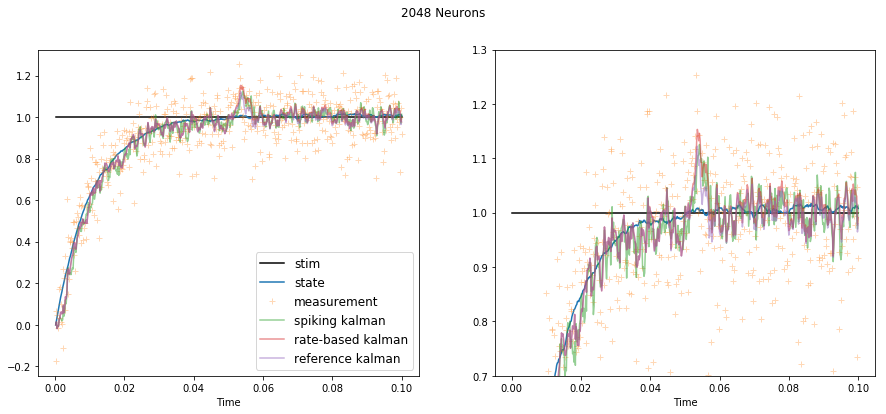

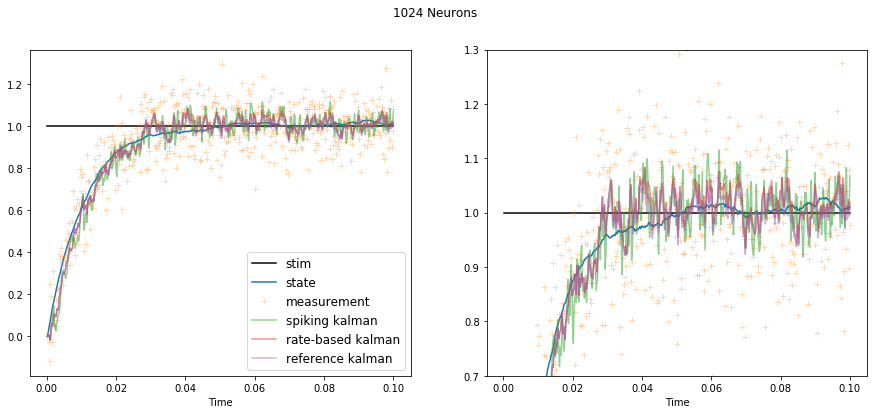

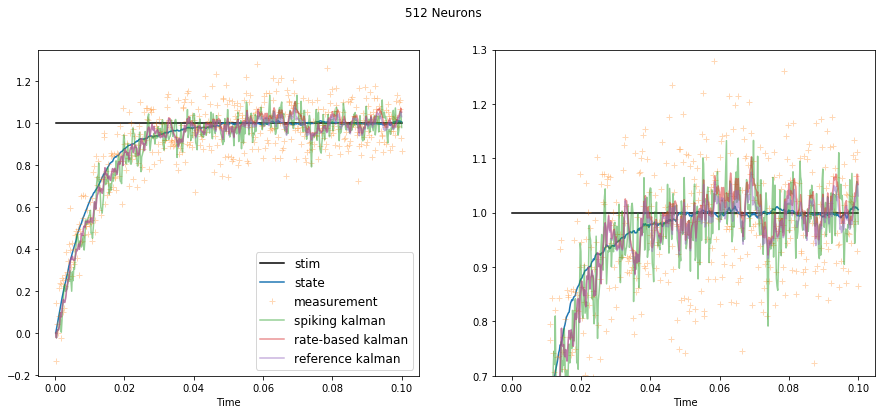

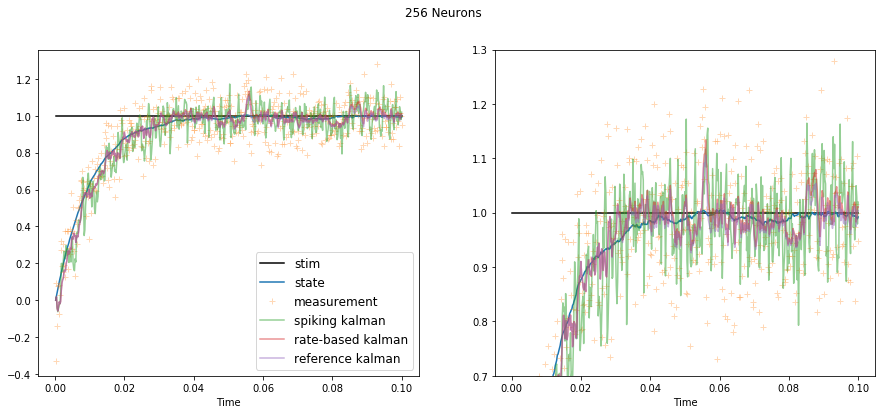

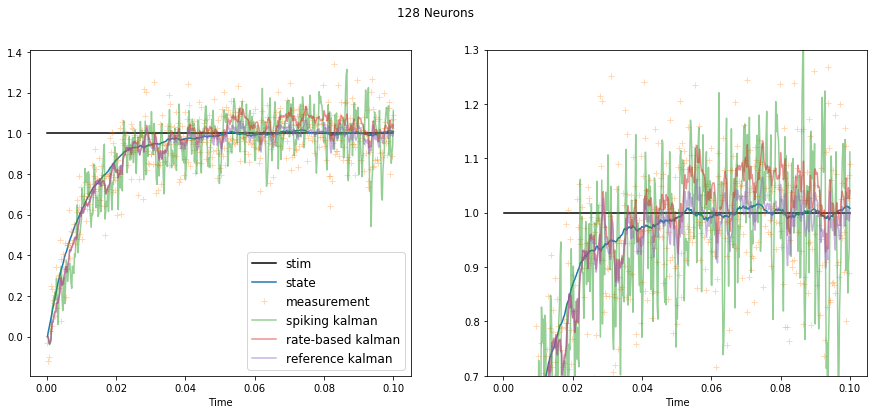

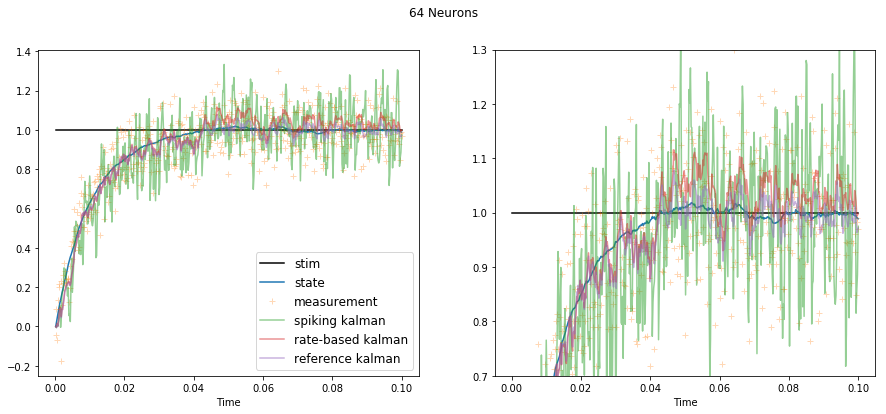

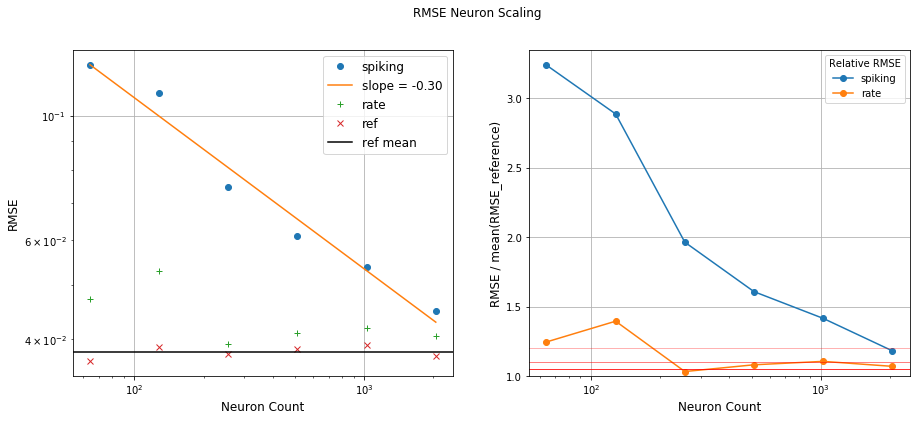

In [25]:
def sweep_k_net():
    """Track the kalman filter error with more neurons"""
    NEURONS = [64, 128, 256, 512, 1024, 2048][::-1]
    rmse_ref = np.zeros(len(NEURONS))
    rmse_rate = np.zeros(len(NEURONS))
    rmse_spiking = np.zeros(len(NEURONS))
    for idx, neurons in enumerate(NEURONS):
        rmse_ref[idx], rmse_rate[idx], rmse_spiking[idx] = test_kalman_net(neurons=neurons, plot=True)
    
    log_nrns = np.log2(NEURONS)
    log_rmse = np.log2(rmse_spiking)
    A_fit = np.ones((len(NEURONS), 2))
    A_fit[:, 0] = log_nrns
    b_fit = log_rmse
    fit = np.linalg.lstsq(A_fit, b_fit, rcond=None)
    fit_slope, fit_intercept = fit[0]
    fit_rmse = 2**(fit_slope*log_nrns+fit_intercept)
    
    fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
    axs[0].loglog(NEURONS, rmse_spiking, 'o', label="spiking")
    axs[0].loglog(NEURONS, fit_rmse, label="slope = {:.2f}".format(fit_slope))
    axs[0].loglog(NEURONS, rmse_rate, '+', label="rate")
    axs[0].loglog(NEURONS, rmse_ref, 'x', label="ref")
    axs[0].axhline(np.mean(rmse_ref), color="k", label="ref mean")
    axs[0].set_xlabel("Neuron Count", fontsize=12)
    axs[0].set_ylabel("RMSE", fontsize=12)
    axs[0].legend(loc="upper right", fontsize=12)
    axs[0].grid()
    axs[1].semilogx(NEURONS, rmse_spiking/np.mean(rmse_ref), '-o', label="spiking")
    axs[1].semilogx(NEURONS, rmse_rate/np.mean(rmse_ref), '-o', label="rate")
    axs[1].set_xlabel("Neuron Count", fontsize=12)
    axs[1].set_ylabel("RMSE / mean(RMSE_reference)", fontsize=12)
    axs[1].axhline(1.2, color='r', alpha=0.3, linewidth=1)
    axs[1].axhline(1.1, color='r', alpha=0.5, linewidth=1)
    axs[1].axhline(1.05, color='r', alpha=0.8, linewidth=1)
    axs[1].grid()
    axs[1].set_ylim((1, axs[1].get_ylim()[1]))
    axs[1].legend(loc="upper right", title="Relative RMSE")
    fig.suptitle("RMSE Neuron Scaling", fontsize=12)
    plt.show()
sweep_k_net()